<a href="https://colab.research.google.com/github/HappyGithub-dev/Food-Image-Recognition-and-Calorie-Estimation/blob/main/FIRCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib pillow

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os, json, time
from PIL import Image
import xml.etree.ElementTree as ET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = "/content/drive/MyDrive/Dataset for Project"

xml_folder = base_path
train_json_path = os.path.join(base_path, "annotations_train.json")

class_mapping = {
    "apple": 1,
    "banana": 2,
    "orange": 3
}

In [ ]:
print(class_mapping["apple"])

1


In [ ]:
def create_annotations(xml_folder, json_out):
    annotations = {}
    for xml_file in os.listdir(xml_folder):
        if not xml_file.endswith(".xml"):
            continue
        tree = ET.parse(os.path.join(xml_folder, xml_file))
        root = tree.getroot()

        filename = root.find("filename").text
        boxes, labels = [], []

        for obj in root.findall("object"):
            label = obj.find("name").text
            labels.append(class_mapping[label])
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])


        annotations[filename] = {"boxes": boxes, "labels": labels}

    with open(json_out, "w") as f:
        json.dump(annotations, f, indent=4)
    print(f"Saved {len(annotations)} annotations to {json_out}")


# Call it
create_annotations(xml_folder, train_json_path)

Saved 240 annotations to /content/drive/MyDrive/Dataset for Project/annotations_train.json


In [ ]:
with open(train_json_path, 'r') as f:  # 'r' stands for READ mode
    all_data = json.load(f)

target_image = "apple_1.jpg"

if target_image in all_data:
    print(f"{target_image}")

    print(all_data[target_image])

else:
    print(f"Could not find {target_image} in the file.")

apple_1.jpg
{'boxes': [[8, 15, 331, 349]], 'labels': [1]}


In [ ]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, root, annotations_file, transform=None):
        self.root = root
        self.transform = transform
        with open(annotations_file) as f:
            self.annotations = json.load(f)
        self.images = list(self.annotations.keys())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path).convert("RGB")

        target_data = self.annotations[img_name]
        boxes = torch.tensor(target_data["boxes"], dtype=torch.float32)
        labels = torch.tensor(target_data["labels"], dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            img = self.transform(img)
        return img, target

In [ ]:
import torch

# 1. Create the Dataset Instance
# This runs __init__ and loads the JSON file
dataset = ObjectDetectionDataset(root=xml_folder, annotations_file=train_json_path)

# 2. Fetch the first item (Index 0)
# This triggers __getitem__(0)
img, target = dataset[0]

# 3. Print the 'img' details
print("--- IMAGE ---")
print(f"Type: {type(img)}") # Should say <class 'PIL.Image.Image'>
print(f"Size: {img.size}")   # (Width, Height)
print(img)                   # Shows the image mode (RGB) and address

# 4. Print the 'target' details
print("\n--- TARGET ---")
# This prints the dictionary containing the Tensors
for key, value in target.items():
    print(f"{key}:")
    print(value)
    print(f"Shape: {value.shape}\n")

--- IMAGE ---
Type: <class 'PIL.Image.Image'>
Size: (645, 645)
<PIL.Image.Image image mode=RGB size=645x645 at 0x7AF31627AF00>

--- TARGET ---
boxes:
tensor([[114., 289., 290., 459.],
        [282., 296., 449., 448.],
        [ 57., 284., 211., 424.],
        [481., 239., 615., 387.]])
Shape: torch.Size([4, 4])

labels:
tensor([1, 1, 1, 1])
Shape: torch.Size([4])



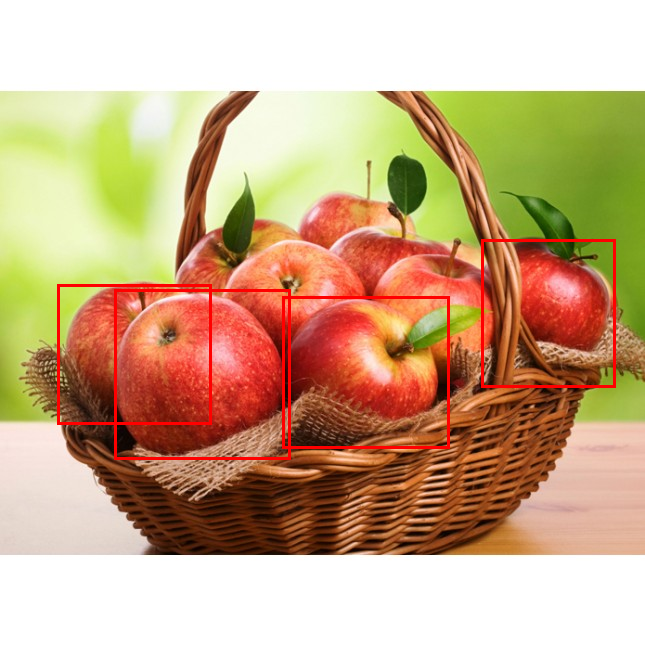

In [ ]:
from PIL import ImageDraw

# Create a copy so we don't mess up the original
img_show = img.copy()
draw = ImageDraw.Draw(img_show)

# Get the box coordinates from the tensor
# .tolist() converts the Tensor back to a simple Python list
boxes = target["boxes"].tolist()

for box in boxes:
    # draw.rectangle takes [xmin, ymin, xmax, ymax]
    draw.rectangle(box, outline="red", width=3)

# Display the image
img_show  # Or just type 'img_show' on the last line of a Colab cell

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.5)
])


train_dataset = ObjectDetectionDataset(
    root=base_path,
    annotations_file=train_json_path,
    transform=train_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)

In [ ]:
print("Train samples:", len(train_dataset))

Train samples: 240


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 4 # 3 fruits + background
in_features = model.roi_heads.box_predictor.cls_score.in_features ## Review this part exactly
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)
print(in_features)

cuda
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 192MB/s]


1024


In [ ]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0.0


def compute_train_accuracy(model, data_loader, device, iou_threshold=0.5, score_threshold=0.5):
    "Compute simple training accuracy: IoU≥0.5"
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            for output, target in zip(outputs, targets):
                gt_boxes = target["boxes"].cpu().numpy()
                gt_labels = target["labels"].cpu().numpy()
                pred_boxes = output["boxes"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                total += len(gt_boxes)
                for gt_box, gt_label in zip(gt_boxes, gt_labels):
                    best_iou, best_label = 0, None
                    for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores):
                        if pred_score < score_threshold:
                            continue
                        iou = compute_iou(gt_box, pred_box)
                        if iou > best_iou:
                            best_iou, best_label = iou, pred_label
                    if best_iou >= iou_threshold and best_label == gt_label:
                        correct += 1
    return correct / total if total > 0 else 0.0

In [ ]:
import torch.optim as optim
import time

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.005)

num_epochs = 5

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward + backward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()


        print(f"Epoch {epoch+1} | Batch {i+1}/{len(train_loader)} | Loss: {losses.item():.4f}")

    # After each epoch, compute accuracy using our function
    avg_loss = epoch_loss / len(train_loader)
    train_acc = compute_train_accuracy(model, train_loader, device)
    print(f"Epoch [{epoch+1}/{num_epochs}]  Avg Loss: {avg_loss:.4f}  |  Train Accuracy: {train_acc:.4f}")

end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

Epoch 1 | Batch 1/60 | Loss: 1.8026
Epoch 1 | Batch 2/60 | Loss: 1.3989
Epoch 1 | Batch 3/60 | Loss: 0.9858
Epoch 1 | Batch 4/60 | Loss: 0.5050
Epoch 1 | Batch 5/60 | Loss: 0.7730
Epoch 1 | Batch 6/60 | Loss: 0.4306
Epoch 1 | Batch 7/60 | Loss: 0.5168
Epoch 1 | Batch 8/60 | Loss: 0.3795
Epoch 1 | Batch 9/60 | Loss: 0.8020
Epoch 1 | Batch 10/60 | Loss: 0.5140
Epoch 1 | Batch 11/60 | Loss: 0.4848


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 | Batch 12/60 | Loss: 0.4274
Epoch 1 | Batch 13/60 | Loss: 0.9212
Epoch 1 | Batch 14/60 | Loss: 0.8767
Epoch 1 | Batch 15/60 | Loss: 0.7068
Epoch 1 | Batch 16/60 | Loss: 0.6019
Epoch 1 | Batch 17/60 | Loss: 0.3149
Epoch 1 | Batch 18/60 | Loss: 0.9826
Epoch 1 | Batch 19/60 | Loss: 0.6586
Epoch 1 | Batch 20/60 | Loss: 0.3877
Epoch 1 | Batch 21/60 | Loss: 0.4598
Epoch 1 | Batch 22/60 | Loss: 0.4288
Epoch 1 | Batch 23/60 | Loss: 0.2690
Epoch 1 | Batch 24/60 | Loss: 0.2402
Epoch 1 | Batch 25/60 | Loss: 0.3933
Epoch 1 | Batch 26/60 | Loss: 0.8492


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 | Batch 27/60 | Loss: 0.3130
Epoch 1 | Batch 28/60 | Loss: 0.3937
Epoch 1 | Batch 29/60 | Loss: 0.3828
Epoch 1 | Batch 30/60 | Loss: 0.3278
Epoch 1 | Batch 31/60 | Loss: 0.7303
Epoch 1 | Batch 32/60 | Loss: 0.3882
Epoch 1 | Batch 33/60 | Loss: 0.3490
Epoch 1 | Batch 34/60 | Loss: 0.6929
Epoch 1 | Batch 35/60 | Loss: 0.3911
Epoch 1 | Batch 36/60 | Loss: 0.8159
Epoch 1 | Batch 37/60 | Loss: 0.5671
Epoch 1 | Batch 38/60 | Loss: 0.3604
Epoch 1 | Batch 39/60 | Loss: 0.3139
Epoch 1 | Batch 40/60 | Loss: 0.3271
Epoch 1 | Batch 41/60 | Loss: 0.4473
Epoch 1 | Batch 42/60 | Loss: 0.5396
Epoch 1 | Batch 43/60 | Loss: 0.3791
Epoch 1 | Batch 44/60 | Loss: 0.2630
Epoch 1 | Batch 45/60 | Loss: 0.3740
Epoch 1 | Batch 46/60 | Loss: 0.2602
Epoch 1 | Batch 47/60 | Loss: 0.5409
Epoch 1 | Batch 48/60 | Loss: 0.2178
Epoch 1 | Batch 49/60 | Loss: 0.5134
Epoch 1 | Batch 50/60 | Loss: 0.5886
Epoch 1 | Batch 51/60 | Loss: 0.3080
Epoch 1 | Batch 52/60 | Loss: 0.6374
Epoch 1 | Batch 53/60 | Loss: 0.5394
E

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5]  Avg Loss: 0.5307  |  Train Accuracy: 0.0000
Epoch 2 | Batch 1/60 | Loss: 0.4387
Epoch 2 | Batch 2/60 | Loss: 0.6562
Epoch 2 | Batch 3/60 | Loss: 0.2982


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2 | Batch 4/60 | Loss: 0.4431
Epoch 2 | Batch 5/60 | Loss: 0.3678
Epoch 2 | Batch 6/60 | Loss: 0.2302
Epoch 2 | Batch 7/60 | Loss: 0.5904
Epoch 2 | Batch 8/60 | Loss: 0.2025
Epoch 2 | Batch 9/60 | Loss: 0.3595
Epoch 2 | Batch 10/60 | Loss: 0.5131
Epoch 2 | Batch 11/60 | Loss: 0.2237
Epoch 2 | Batch 12/60 | Loss: 0.3819
Epoch 2 | Batch 13/60 | Loss: 0.4100
Epoch 2 | Batch 14/60 | Loss: 0.2754
Epoch 2 | Batch 15/60 | Loss: 0.2828
Epoch 2 | Batch 16/60 | Loss: 0.2925
Epoch 2 | Batch 17/60 | Loss: 0.2023
Epoch 2 | Batch 18/60 | Loss: 0.2337
Epoch 2 | Batch 19/60 | Loss: 0.5173
Epoch 2 | Batch 20/60 | Loss: 0.7135
Epoch 2 | Batch 21/60 | Loss: 0.3661
Epoch 2 | Batch 22/60 | Loss: 0.2333
Epoch 2 | Batch 23/60 | Loss: 0.5656
Epoch 2 | Batch 24/60 | Loss: 0.3269
Epoch 2 | Batch 25/60 | Loss: 0.2296
Epoch 2 | Batch 26/60 | Loss: 0.6041
Epoch 2 | Batch 27/60 | Loss: 0.2790
Epoch 2 | Batch 28/60 | Loss: 0.4630
Epoch 2 | Batch 29/60 | Loss: 0.4242
Epoch 2 | Batch 30/60 | Loss: 0.1885
Epoch 2

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/5]  Avg Loss: 0.3854  |  Train Accuracy: 0.7548
Epoch 3 | Batch 1/60 | Loss: 0.5039
Epoch 3 | Batch 2/60 | Loss: 0.1478
Epoch 3 | Batch 3/60 | Loss: 0.3923
Epoch 3 | Batch 4/60 | Loss: 0.3554
Epoch 3 | Batch 5/60 | Loss: 0.4620
Epoch 3 | Batch 6/60 | Loss: 0.3489
Epoch 3 | Batch 7/60 | Loss: 0.5722
Epoch 3 | Batch 8/60 | Loss: 0.3400
Epoch 3 | Batch 9/60 | Loss: 0.1687
Epoch 3 | Batch 10/60 | Loss: 0.5263
Epoch 3 | Batch 11/60 | Loss: 0.3531
Epoch 3 | Batch 12/60 | Loss: 0.2326
Epoch 3 | Batch 13/60 | Loss: 0.2760
Epoch 3 | Batch 14/60 | Loss: 0.3444
Epoch 3 | Batch 15/60 | Loss: 0.3107
Epoch 3 | Batch 16/60 | Loss: 0.5501
Epoch 3 | Batch 17/60 | Loss: 0.2001
Epoch 3 | Batch 18/60 | Loss: 0.1711
Epoch 3 | Batch 19/60 | Loss: 0.5241
Epoch 3 | Batch 20/60 | Loss: 0.1170
Epoch 3 | Batch 21/60 | Loss: 0.3586
Epoch 3 | Batch 22/60 | Loss: 0.2035
Epoch 3 | Batch 23/60 | Loss: 0.5988
Epoch 3 | Batch 24/60 | Loss: 0.3638
Epoch 3 | Batch 25/60 | Loss: 0.3889


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 | Batch 26/60 | Loss: 0.3908
Epoch 3 | Batch 27/60 | Loss: 0.5287
Epoch 3 | Batch 28/60 | Loss: 0.4461
Epoch 3 | Batch 29/60 | Loss: 0.1834
Epoch 3 | Batch 30/60 | Loss: 0.2544
Epoch 3 | Batch 31/60 | Loss: 0.2642
Epoch 3 | Batch 32/60 | Loss: 0.3082
Epoch 3 | Batch 33/60 | Loss: 0.2422
Epoch 3 | Batch 34/60 | Loss: 0.4188
Epoch 3 | Batch 35/60 | Loss: 0.2476
Epoch 3 | Batch 36/60 | Loss: 0.1083
Epoch 3 | Batch 37/60 | Loss: 0.2209
Epoch 3 | Batch 38/60 | Loss: 0.3501
Epoch 3 | Batch 39/60 | Loss: 0.4517
Epoch 3 | Batch 40/60 | Loss: 0.3786
Epoch 3 | Batch 41/60 | Loss: 0.5857
Epoch 3 | Batch 42/60 | Loss: 0.2668
Epoch 3 | Batch 43/60 | Loss: 0.3851
Epoch 3 | Batch 44/60 | Loss: 0.2514
Epoch 3 | Batch 45/60 | Loss: 0.5903
Epoch 3 | Batch 46/60 | Loss: 0.2237
Epoch 3 | Batch 47/60 | Loss: 0.1839
Epoch 3 | Batch 48/60 | Loss: 0.2228


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 | Batch 49/60 | Loss: 0.3281
Epoch 3 | Batch 50/60 | Loss: 0.5602
Epoch 3 | Batch 51/60 | Loss: 0.3186
Epoch 3 | Batch 52/60 | Loss: 0.1431
Epoch 3 | Batch 53/60 | Loss: 0.1688
Epoch 3 | Batch 54/60 | Loss: 0.4413
Epoch 3 | Batch 55/60 | Loss: 0.4710
Epoch 3 | Batch 56/60 | Loss: 0.0902
Epoch 3 | Batch 57/60 | Loss: 0.6636
Epoch 3 | Batch 58/60 | Loss: 0.2566
Epoch 3 | Batch 59/60 | Loss: 0.1763
Epoch 3 | Batch 60/60 | Loss: 0.2856


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/5]  Avg Loss: 0.3370  |  Train Accuracy: 0.7441
Epoch 4 | Batch 1/60 | Loss: 0.2296
Epoch 4 | Batch 2/60 | Loss: 0.2833
Epoch 4 | Batch 3/60 | Loss: 0.1953
Epoch 4 | Batch 4/60 | Loss: 0.1594
Epoch 4 | Batch 5/60 | Loss: 0.1653
Epoch 4 | Batch 6/60 | Loss: 0.3853
Epoch 4 | Batch 7/60 | Loss: 0.3882
Epoch 4 | Batch 8/60 | Loss: 0.3501
Epoch 4 | Batch 9/60 | Loss: 0.2968
Epoch 4 | Batch 10/60 | Loss: 0.3375
Epoch 4 | Batch 11/60 | Loss: 0.1789
Epoch 4 | Batch 12/60 | Loss: 0.3954
Epoch 4 | Batch 13/60 | Loss: 0.3018
Epoch 4 | Batch 14/60 | Loss: 0.3952
Epoch 4 | Batch 15/60 | Loss: 0.0736
Epoch 4 | Batch 16/60 | Loss: 0.3532
Epoch 4 | Batch 17/60 | Loss: 0.3541
Epoch 4 | Batch 18/60 | Loss: 0.2120
Epoch 4 | Batch 19/60 | Loss: 0.1668
Epoch 4 | Batch 20/60 | Loss: 0.1630
Epoch 4 | Batch 21/60 | Loss: 0.1522
Epoch 4 | Batch 22/60 | Loss: 0.3383
Epoch 4 | Batch 23/60 | Loss: 0.1592
Epoch 4 | Batch 24/60 | Loss: 0.3146
Epoch 4 | Batch 25/60 | Loss: 0.6374
Epoch 4 | Batch 26/60 | Los

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4 | Batch 42/60 | Loss: 0.1601
Epoch 4 | Batch 43/60 | Loss: 0.2094
Epoch 4 | Batch 44/60 | Loss: 0.2699
Epoch 4 | Batch 45/60 | Loss: 0.1514
Epoch 4 | Batch 46/60 | Loss: 0.2727
Epoch 4 | Batch 47/60 | Loss: 0.1045
Epoch 4 | Batch 48/60 | Loss: 0.2473
Epoch 4 | Batch 49/60 | Loss: 0.4308
Epoch 4 | Batch 50/60 | Loss: 0.2976
Epoch 4 | Batch 51/60 | Loss: 0.3147
Epoch 4 | Batch 52/60 | Loss: 0.2272


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4 | Batch 53/60 | Loss: 0.2378
Epoch 4 | Batch 54/60 | Loss: 0.0905
Epoch 4 | Batch 55/60 | Loss: 0.3265
Epoch 4 | Batch 56/60 | Loss: 0.5423
Epoch 4 | Batch 57/60 | Loss: 0.2440
Epoch 4 | Batch 58/60 | Loss: 0.1534
Epoch 4 | Batch 59/60 | Loss: 0.1550
Epoch 4 | Batch 60/60 | Loss: 0.1570


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/5]  Avg Loss: 0.2876  |  Train Accuracy: 0.7914
Epoch 5 | Batch 1/60 | Loss: 0.3550
Epoch 5 | Batch 2/60 | Loss: 0.0720
Epoch 5 | Batch 3/60 | Loss: 0.6127
Epoch 5 | Batch 4/60 | Loss: 0.4833


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5 | Batch 5/60 | Loss: 0.1181
Epoch 5 | Batch 6/60 | Loss: 0.1827
Epoch 5 | Batch 7/60 | Loss: 0.1273
Epoch 5 | Batch 8/60 | Loss: 0.4486
Epoch 5 | Batch 9/60 | Loss: 0.2331
Epoch 5 | Batch 10/60 | Loss: 0.1392
Epoch 5 | Batch 11/60 | Loss: 0.2841
Epoch 5 | Batch 12/60 | Loss: 0.3804
Epoch 5 | Batch 13/60 | Loss: 0.1746
Epoch 5 | Batch 14/60 | Loss: 0.1406
Epoch 5 | Batch 15/60 | Loss: 0.1990
Epoch 5 | Batch 16/60 | Loss: 0.2726
Epoch 5 | Batch 17/60 | Loss: 0.3338
Epoch 5 | Batch 18/60 | Loss: 0.3287
Epoch 5 | Batch 19/60 | Loss: 0.1802
Epoch 5 | Batch 20/60 | Loss: 0.1967
Epoch 5 | Batch 21/60 | Loss: 0.3053
Epoch 5 | Batch 22/60 | Loss: 0.1192
Epoch 5 | Batch 23/60 | Loss: 0.1063
Epoch 5 | Batch 24/60 | Loss: 0.3701
Epoch 5 | Batch 25/60 | Loss: 0.4012
Epoch 5 | Batch 26/60 | Loss: 0.2232
Epoch 5 | Batch 27/60 | Loss: 0.1214
Epoch 5 | Batch 28/60 | Loss: 0.4078
Epoch 5 | Batch 29/60 | Loss: 0.3477
Epoch 5 | Batch 30/60 | Loss: 0.1744
Epoch 5 | Batch 31/60 | Loss: 0.3074
Epoch 

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/5]  Avg Loss: 0.2834  |  Train Accuracy: 0.8129

Total training time: 544.62 seconds


In [ ]:
test_image_path = "/content/assets-task_01k4t6wj8pen4bwyrtw63b5s11-1757521363_img_0-1.webp"

In [ ]:
!pip install opencv-python

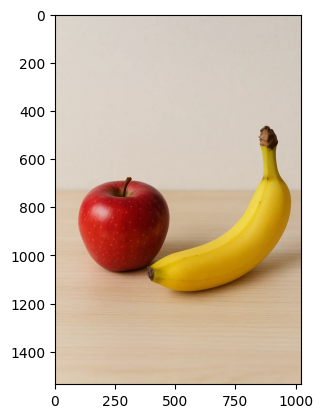

In [ ]:
from PIL import Image
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image
img = Image.open(test_image_path).convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(img).to(device)

plt.imshow(img)

# Run inference
model.eval()
with torch.no_grad():
    preds = model([img_tensor])

preds = preds[0]

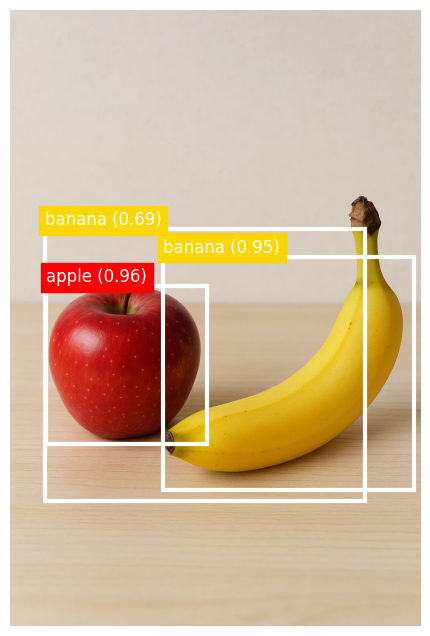

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Extract predictions
boxes = preds['boxes'].cpu().numpy()
labels = preds['labels'].cpu().numpy()
scores = preds['scores'].cpu().numpy()

# Keep only confident detections
confidence_threshold = 0.5
keep = scores >= confidence_threshold
boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

# Labels
label_map = {1: "apple", 2: "banana", 3: "orange"}
colors = {1: 'red', 2: 'gold', 3: 'green'}

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.array(img))

for box, label, score in zip(boxes, labels, scores):
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=3, edgecolor='white', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 10, f"{label_map[label]} ({score:.2f})",
            color='white', fontsize=12, backgroundcolor=colors[label])

plt.axis("off")
plt.show()

In [ ]:
boxes = preds['boxes'].cpu().numpy()
labels = preds['labels'].cpu().numpy()
scores = preds['scores'].cpu().numpy()

confidence_threshold = 0.5
keep = scores >= confidence_threshold

boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

label_map = {1: "apple", 2: "banana", 3: "orange"}

for box, label, score in zip(boxes, labels, scores):
    xmin, ymin, xmax, ymax = box
    print(f"{label_map[label]} ({score:.2f}), Bounding Box Coordinates "
          f"x={(xmin + xmax)/2:.1f}, y={(ymin+ymax)/2:.1f}, w={(xmax - xmin):.1f}, h={(ymax-ymin):.1f}")

apple (0.96), Bounding Box Coordinates x=290.1, y=885.2, w=399.8, h=394.0
banana (0.95), Bounding Box Coordinates x=694.7, y=905.7, w=625.2, h=582.3
banana (0.69), Bounding Box Coordinates x=485.6, y=885.6, w=799.4, h=678.9


In [ ]:
calorie_lookup = {
    'apple': 95,
    'banana': 105,
    'orange': 62
}

def estimate_total_calories(detected_objects):
    """
    detected_objects: A list of strings (e.g., ['apple', 'apple', 'orange'])
    returns: Total calorie count and a breakdown
    """
    total_kcal = 0
    breakdown = {}

    for item in detected_objects:
        item = item.lower() # Ensure case-insensitivity
        if item in calorie_lookup:
            calories = calorie_lookup[item]
            total_kcal += calories

            # Keep track of counts for the final report
            breakdown[item] = breakdown.get(item, 0) + 1

    return total_kcal, breakdown

# Example usage:
# If your model detected:
my_detections = ['apple', 'banana', 'apple']

total, report = estimate_total_calories(my_detections)

print(f"Total Estimated Calories: {total} kcal")
print(f"Items detected: {report}")

Total Estimated Calories: 295 kcal
Items detected: {'apple': 2, 'banana': 1}
